# BBC News classification using Matrix Factorization

### 1.- Loading data and initialization

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(".\\data\\BBC News Train.csv")

In [3]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
train.shape

(1490, 3)

### 2.- Exploratory Data Analysis

<Axes: xlabel='Category'>

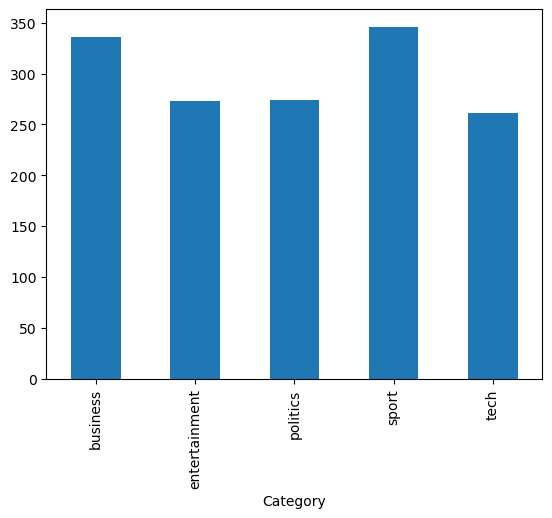

In [5]:
train.groupby('Category').size().plot(kind='bar')

In [6]:


def world_cloud_auxiliar(category):
    # Sample text
    texts = train.loc[train['Category']==category]
    text = " ".join(texts['Text'])
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
    plt.show()


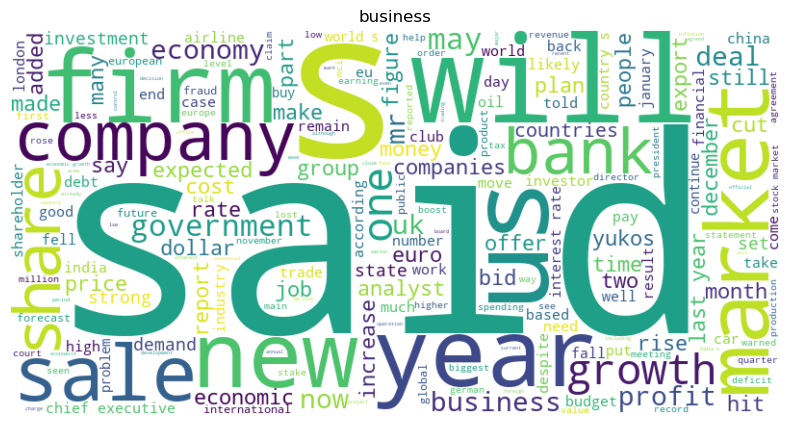

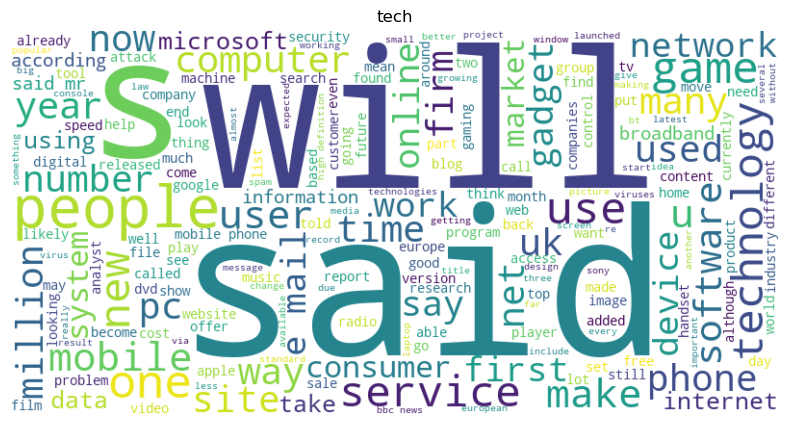

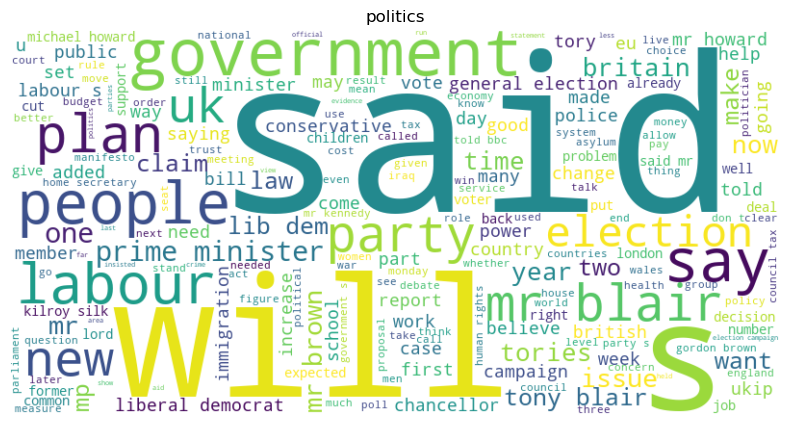

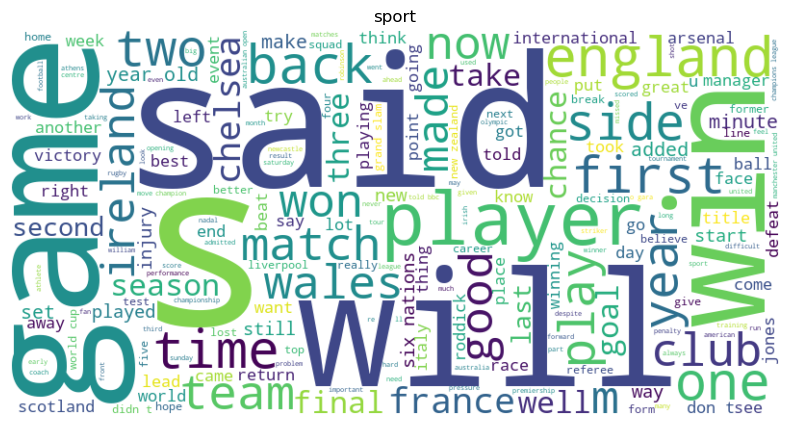

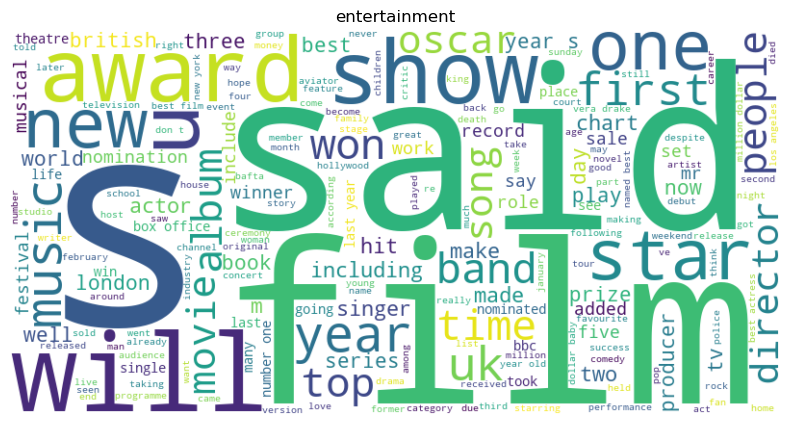

[None, None, None, None, None]

In [7]:

categories = train['Category'].unique()
[world_cloud_auxiliar(c) for c in categories]

A naive visualization of cloud of words matches with our intuition

### Preprocessing



In [8]:
# we generate category mappings to numbers and the inverse mapping
map_categories = dict([(x[0],x[1]) for x in zip(categories,range(0,len(categories)))])
imap_categories = dict([(x[1],x[0]) for x in zip(categories,range(0,len(categories)))])
print(map_categories)
print(imap_categories)

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}
{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}


In [9]:
test = pd.read_csv(".\\data\\BBC News Test.csv")
test_y = pd.read_csv(".\\data\\BBC News Sample Solution.csv")
test['Category']=test_y['Category']
test['category_id'] = [map_categories[x] for x in test_y['Category']]

In [10]:
from nltk.corpus import stopwords
import string

punctuation = string.punctuation
train['Text'] = train['Text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]).split())
test['Text'] = test['Text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]).split())
test.head()

,ArticleId,Text,Category,category_id
0,1018,"[qpr, keeper, day, heads, for, preston, queens...",sport,3
1,1319,"[software, watching, while, you, work, softwar...",tech,1
2,1138,"[d, arcy, injury, adds, to, ireland, woe, gord...",business,0
3,459,"[india, s, reliance, family, feud, heats, up, ...",entertainment,4
4,1020,"[boro, suffer, morrison, injury, blow, middles...",politics,2


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = stopwords.words('english')

train['Text'] = train['Text'].apply(lambda x: ' '.join([i for i in x if i not in stop_words]))
test['Text'] = test['Text'].apply(lambda x: ' '.join([i for i in x if i not in stop_words]))
train.head()

,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens maj...,business
3,1976,lifestyle governs mobile choice faster better ...,tech
4,917,enron bosses 168m payout eighteen former enron...,business


### 3.- Embedding

In [13]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

pl = Pipeline([('count_vect', CountVectorizer()), ('tfidf', TfidfTransformer())])
X_train = pl.fit_transform(train['Text'])
X_test = pl.transform(test['Text'])
X_train.shape

CPU times: total: 266 ms
Wall time: 264 ms


(1490, 27105)

In [14]:
#so we can encode like this:
train['category_id']= list(map(lambda x: map_categories[x], train['Category']))
test['category_id']= list(map(lambda x: map_categories[x], test['Category']))
train.head()

,ArticleId,Text,Category,category_id
0,1833,worldcom exboss launches defence lawyers defen...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens maj...,business,0
3,1976,lifestyle governs mobile choice faster better ...,tech,1
4,917,enron bosses 168m payout eighteen former enron...,business,0


Fit the Matrix decomposition with 5 latent factors

In [15]:
model = NMF(n_components=5) 
W =model.fit_transform(X_train)  # Fit NMF and obtain the basis matrix W
H = model.components_

We check the shapes of the factor matrices, and then compare the frequencies of the true label 

In [16]:
print(W.shape)
print(H.shape)
cluster_labels = W.argmax(axis=1)  #  Selecting the predictions 
labels = pd.DataFrame({'category_id':train['category_id'],'Category':train['Category'],'predicted':cluster_labels})
labels.head()

(1490, 5)
(5, 27105)


,category_id,Category,predicted
0,0,business,4
1,0,business,4
2,0,business,4
3,1,tech,2
4,0,business,4


Here we check what actual mapping from predicted lattent factor to our actual categories

In [17]:
labels2 = labels.groupby(['category_id','Category','predicted'],as_index=False).size().sort_values(by='size',ascending=False)
labels2.head(10)

,category_id,Category,predicted,size
13,3,sport,0,342
4,0,business,4,311
6,1,tech,2,252
10,2,politics,1,245
19,4,entertainment,3,215
18,4,entertainment,2,42
12,2,politics,4,18
1,0,business,1,12
2,0,business,2,11
11,2,politics,2,9


In [18]:
#we can build a decoder 
decoder = dict([z for z in zip(labels2['predicted'][:5],labels2['category_id'][:5])])
decoder

{0: 3, 4: 0, 2: 1, 1: 2, 3: 4}

In [19]:
predicted=[decoder[x] for x in cluster_labels]


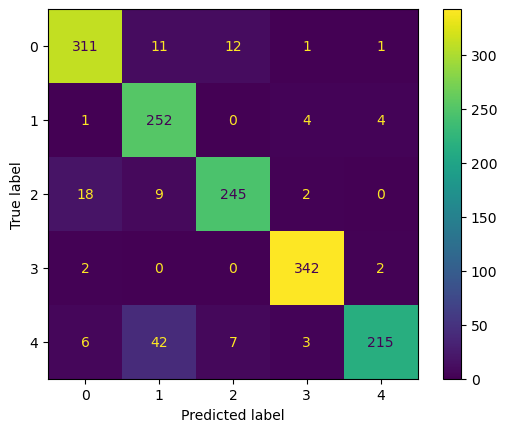

In [20]:
cm = confusion_matrix(train['category_id'], predicted)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Both the confusion matrix and the accuracy look pretty good 

In [21]:
accuracy_score(train['category_id'], predicted)

0.9161073825503355

## Test Data

### We use the same pipeline we fitted with the training data

In [22]:
X_test = pl.transform(test['Text'])
X_test.shape

(735, 27105)

### Now we use our model fitted with training data to tansform our test data

In [23]:
W =model.transform(X_test)

In [24]:
print(W.shape)
print(H.shape)
cluster_labels = W.argmax(axis=1)  #  Selecting the predictions 
labels = pd.DataFrame({'category_id':test['category_id'],'Category':test['Category'],'predicted':cluster_labels})
labels.head()

(735, 5)
(5, 27105)


,category_id,Category,predicted
0,3,sport,0
1,1,tech,2
2,0,business,0
3,4,entertainment,4
4,2,politics,0


In [25]:
labels2 = labels.groupby(['category_id','Category','predicted'],as_index=False).size().sort_values(by='size',ascending=False)
labels2.head(10)

,category_id,Category,predicted,size
19,3,sport,4,41
0,0,business,0,36
10,2,politics,0,36
4,0,business,4,36
6,1,tech,1,35
9,1,tech,4,35
12,2,politics,2,35
24,4,entertainment,4,35
22,4,entertainment,2,34
17,3,sport,2,34


In [26]:
predicted=[decoder[x] for x in cluster_labels]

In [27]:
submission = pd.read_csv('./data/BBC News Sample Solution.csv')
predicted=[imap_categories[decoder[x]] for x in cluster_labels]
print(predicted[0:5])
submission['Category'] = predicted
submission.to_csv('data/nmf_submission_v2.csv', index=False)

['sport', 'tech', 'sport', 'business', 'sport']


After submission to Kaggle for scorign we got an accuracy of 0.98503, whic is pretty goood.

![title](data/nmf_scoring_kaggle.png)

## 4.- Supervised Classifier, logistic Regression.

score : 0.9979865771812081


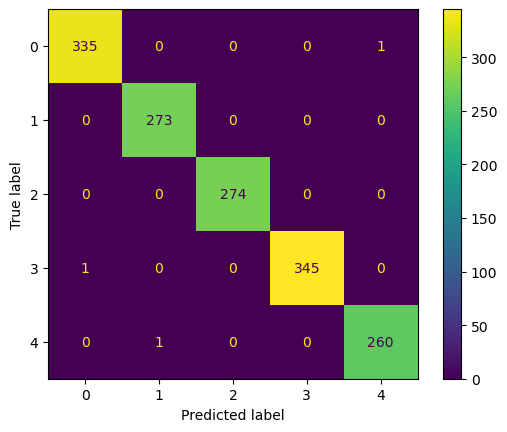

In [28]:
from sklearn.linear_model import LogisticRegression
y = train['Category']
clf = LogisticRegression(random_state=0).fit(X_train, y)
predicted_logistic = clf.predict(X_train)
print('score :',clf.score(X_train, y))


cm = confusion_matrix(train['Category'], predicted_logistic)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

It is immediatly clear that that even a simple classifier like logistic regression is doing a good job in the taining dataset

In [29]:
predicted_logistic = clf.predict(X_test)
print('score :',clf.score(X_test, test['Category']))




score : 0.19319727891156463


In [30]:
submission = pd.read_csv('./data/BBC News Sample Solution.csv')
submission['Category'] = predicted_logistic
submission.to_csv('data/logistic_submission.csv', index=False)

The logistic regression slightly outperformed the NMF

![title](data/logistic_score_2024-11-29_152553.png)

## 4.- Supervised Classifier, Random Forest Regression.

score : 1.0


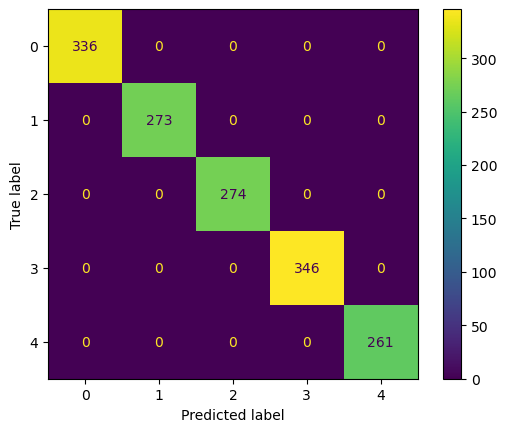

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification


clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
clf.fit(X_train, train['Category'])
predicted_rf = clf.predict(X_train)
cm = confusion_matrix(train['Category'], predicted_rf)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print('score :',clf.score(X_train, train['Category']))

In [32]:
predicted_xgboost = clf.predict(X_test)
submission = pd.read_csv('./data/BBC News Sample Solution.csv')
submission['Category'] = predicted_xgboost
submission.to_csv('data/xgboost_submission.csv', index=False)

The Gradient Boosted model show overfitting, as it separated classes perfectly during training but underperformed the logistic regresion. 
Note that we didn't do any hyperparameter tuning, which is the best practice. With some HP tuning it is likely to outperform the other two methods

![title](data/comparison_2024-11-29_154022.png)